In [1]:
from timeit import default_timer as timer
import random as python_random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.optimizers import Adam

In [2]:
raw_data = pd.read_csv("old_data/raw_metacritic_game_user_comments.csv")
game_info_data = pd.read_csv("src/data/game_info.csv")
train_data = pd.read_csv("src/data/user_data_train_no_comments.csv")
test_data = pd.read_csv("src/data/user_data_test_no_comments.csv")
valid_data = pd.read_csv("src/data/user_data_validation_no_comments.csv")

game_info_data = game_info_data.rename(columns={"Unnamed: 0" : "Id"})

In [3]:
all_data = pd.concat([train_data, test_data, valid_data], ignore_index=True)

In [4]:
# transform usernames into user IDs
user_to_id_map = {}
for i, username in enumerate(np.unique(all_data["Username"])):
    user_to_id_map[username] = i

In [5]:
def format_data(data, usermap):
    # replaces usernames with numeric IDs
    user_ids = []
    for user in data["Username"]:
        user_ids.append(user_to_id_map[user])
        
    data.insert(4, "User_ID", user_ids, allow_duplicates=True)
    data = data.drop(["Unnamed: 0"], axis=1)
    return data

In [6]:
all_data = format_data(all_data, user_to_id_map)
train_data = format_data(train_data, user_to_id_map)
test_data = format_data(test_data, user_to_id_map)
valid_data = format_data(valid_data, user_to_id_map)

In [7]:
n_users = len(np.unique(all_data["Username"]))
n_games = len(game_info_data)

def group_data(data, label):
    """
    dict that maps label -> dataframe
    """
    return dict(tuple(data.groupby(label))) # default sort=True

# map: user -> np.array of game indices
user_game_idx = group_data(all_data, "User_ID")
for key in user_game_idx:
    user_game_idx[key] = user_game_idx[key]["Game_ID"].to_numpy()

# map: game -> np.array of user indices
game_user_idx = group_data(all_data, "Game_ID")
for key in game_user_idx:
    game_user_idx[key] = game_user_idx[key]["User_ID"].to_numpy()

In [13]:
# hyperparameters
embed_dim = 20
seed = 69
n_cycles = 5

# optimizer with custom learning rate
optimizer = Adam(lr = 0.002)

In [41]:
def create_model(embed_dim):
    """
    code following from https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/
    """
    # user embedding
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users + 1, embed_dim, name='User-Embedding')(user_input)
    user_vec = Flatten(name='User-Flatten')(user_embedding)
    user_vec = Dropout(0.2)(user_vec)

    # game embedding
    game_input = Input(shape=[1], name='Game')
    game_embedding = Embedding(n_games + 1, embed_dim, name='Game-Embedding')(game_input)
    game_vec = Flatten(name='Game-Flatten')(game_embedding)
    game_vec = Dropout(0.2)(game_vec)

    # concatenate flattened values 
    concat = concatenate([game_vec, user_vec])
    concat_dropout = Dropout(0.2)(concat)

    # add dense layer (can try more)
    dense_1 = Dense(20, name='Fully-Connected', activation='relu')(concat)

    # define output (can try sigmoid instead of relu)
    result = Dense(1, activation='relu', name='Activation')(dense_1)

    # define model with 2 inputs and 1 output
    model = Model([user_input, game_input], result)
    
    # compile model
    model.compile(optimizer=optimizer, loss=['mse'], metrics=['mean_absolute_error'])
    
    return model

def clone_model(model):
    """
    inefficient cloning
    
    taken from: https://stackoverflow.com/a/54368176
    """
    model_copy = keras.models.clone_model(model)

    model_copy.compile(optimizer=optimizer, loss=['mse'], metrics=['mean_absolute_error'])
    model_copy.set_weights(model.get_weights())
    return model_copy
    
    
def set_seed(seed):
    """
    https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    """
    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    python_random.seed(seed)

    # The below set_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see:
    # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
    tf.random.set_seed(seed)

    # Rest of code follows ...

In [42]:
# define model
set_seed(seed)
main_model = create_model(embed_dim)

In [43]:
# fit model
model_history = main_model.fit([train_data['User_ID'], train_data['Game_ID']],
                                    train_data['Userscore'],
                                    batch_size = 256,
                                    validation_split = 0.005,
                                    epochs = n_cycles,
                                    verbose = 0)

In [44]:
def get_array(series): # transposes a 1d vector
    return np.expand_dims(series.to_numpy(), axis=0).T

# naive RMSE
preds = main_model.predict([get_array(test_data['User_ID']), get_array(test_data['Game_ID'])])
mean_squared_error(preds, test_data['Userscore'], squared=False)

2.592820588388264

(array([6.000e+00, 1.390e+02, 3.410e+02, 8.860e+02, 1.119e+03, 2.074e+03,
        2.501e+03, 3.392e+03, 9.734e+03, 9.187e+03, 1.842e+03]),
 array([0.78267646, 1.5938473 , 2.405018  , 3.2161887 , 4.0273595 ,
        4.8385305 , 5.649701  , 6.4608717 , 7.2720428 , 8.083214  ,
        8.894384  , 9.705555  ], dtype=float32),
 <BarContainer object of 11 artists>)

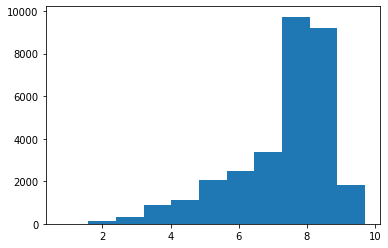

In [38]:
plt.hist(preds, bins=11)

In [33]:
np.sort(np.ravel(preds))

array([0.74361473, 0.9572589 , 1.0798234 , ..., 9.654032  , 9.65859   ,
       9.699793  ], dtype=float32)

In [18]:
preds_lol = main_model.predict([get_array(train_data['User_ID']), get_array(train_data['Game_ID'])])
mean_squared_error(preds_lol, train_data['Userscore'], squared=False)

1.9128285284175168

(array([  994.,  1039.,  1647.,  2536.,  4170.,  7153., 20170., 40616.,
        26018.,  1515.]),
 array([ 0.       ,  1.1151795,  2.230359 ,  3.3455386,  4.460718 ,
         5.5758977,  6.691077 ,  7.806257 ,  8.921436 , 10.036615 ,
        11.151795 ], dtype=float32),
 <BarContainer object of 10 artists>)

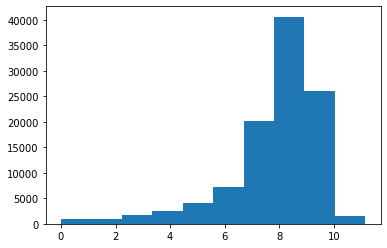

In [20]:
plt.hist(preds_lol)

(array([ 4538.,  1774.,  1691.,  2199.,  2795.,  4011.,  5295.,  8130.,
        14494., 60931.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

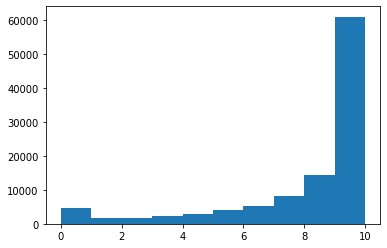

In [21]:
plt.hist(train_data['Userscore'])

In [55]:
def predict_custom(data):
    preds = []
    actual = []
    main_preds = []
    times = []
    set_seed(seed)
    
    start = timer()
    user_counter = 0
    
    store_weights = main_model.get_weights()
    
    for user_id in np.sort(np.unique(data["User_ID"])):
        # ASSUMPTION: user is completely unique and has not been trained on,
        # thus we can use the global var user_game_idx

        user_data = data[data["User_ID"] == user_id]

        user_start = timer()
        for i, game_id in enumerate(user_data["Game_ID"]):
            user_data_drop = user_data.drop(user_data.index[[i]])
            
            pred_input = [np.array([user_id]), np.array([game_id])]
            main_pred = main_model.predict(pred_input)[0][0]

            #model_copy = clone_model(main_model)
            main_model.fit([user_data_drop['User_ID'], user_data_drop['Game_ID']],
                            user_data_drop['Userscore'],
                            batch_size = 256,
                            validation_split = 0.005,
                            epochs = n_cycles,
                            verbose = 0)

            pred = main_model.predict(pred_input)[0][0]
            actual_user_score = user_data.iloc[i]["Userscore"]
            
            preds.append(pred)
            main_preds.append(main_pred)
            actual.append(actual_user_score)
            #print(user_data.iloc[i])
            #print(user_id, game_id)
            
            # reset weights
            main_model.set_weights(store_weights)
            
            #return pred, user_id, game_id
            
            #print(user_data_drop)
            #break
        #break
        user_end = timer()
        times.append(user_end - user_start)
        #print(user_end - user_start)
        user_counter += 1
        if (user_counter % 30) == 0:
            print(user_counter, "time taken so far:", np.sum(times))
        #break # after 1st 
        #if user_counter > 5:
        #    break

    end = timer()
    print("global time:", end - start)

    preds = np.array(preds)
    actual = np.array(actual)
    main_preds = np.array(main_preds)

    return preds, actual, main_preds

In [56]:
preds, actual, main_preds = predict_custom(test_data)

30 time taken so far: 39.07210023800508
60 time taken so far: 69.6352993400069
90 time taken so far: 99.20555910400799
120 time taken so far: 141.336215190011
150 time taken so far: 171.36337227201875
180 time taken so far: 206.90181130801284
210 time taken so far: 243.71598563002772
240 time taken so far: 271.44021226803306
270 time taken so far: 314.5536080720376
300 time taken so far: 358.0297708860271
330 time taken so far: 387.9144600990294
360 time taken so far: 419.2871545030357
390 time taken so far: 447.2716703850383
420 time taken so far: 532.4371023420317
450 time taken so far: 564.7723518340281
480 time taken so far: 588.3916396310196
510 time taken so far: 639.8195150860156
540 time taken so far: 667.9030662620171
570 time taken so far: 704.0798950560238
600 time taken so far: 733.0858641310297
630 time taken so far: 768.4643261360397
660 time taken so far: 802.4812675220528
690 time taken so far: 843.6780532170487
720 time taken so far: 895.118186776057
750 time taken so 

In [57]:
mean_squared_error(preds, actual, squared=False)

2.083831831553614

In [58]:
mean_squared_error(main_preds, actual, squared=False)

2.592820586317312